# PUBG Finish Placement Prediction

Battle Royale-style video games have taken the world by storm. 100 players are dropped onto an island empty-handed and must explore, scavenge, and eliminate other players until only one is left standing, all while the play zone continues to shrink.
### Data fields
-  **DBNOs** Number of enemy players knocked.
-  **assists** Number of enemy players this player damaged that were killed by teammates.
-  **boosts** Number of boost items used.
-  **damageDealt** Total damage dealt. Note: Self inflicted damage is subtracted.
-  **headshotKills** Number of enemy players killed with headshots.
-  **heals** Number of healing items used.
-  **Id** Player’s Id
-  **killPlace** Ranking in match of number of enemy players killed.
-  **killPoints** Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
-  **killStreaks** Max number of enemy players killed in a short amount of time.
-  **kills** Number of enemy players killed.
-  **longestKill** Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
-  **matchDuration** Duration of match in seconds.
-  **matchId** ID to identify match. There are no matches that are in both the training and testing set.
-  **matchType** String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
-  **rankPoints** Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
-  **revives** Number of times this player revived teammates.
-  **rideDistance** Total distance traveled in vehicles measured in meters.
-  **roadKills** Number of kills while in a vehicle.
-  **swimDistance** Total distance traveled by swimming measured in meters.
-  **teamKills** Number of times this player killed a teammate.
-  **vehicleDestroys** Number of vehicles destroyed.
-  **walkDistance** Total distance traveled on foot measured in meters.
-  **weaponsAcquired** Number of weapons picked up.
-  **winPoints** Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
-  **groupId** ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
-  **numGroups** Number of groups we have data for in the match.
-  **maxPlace** Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
-  **winPlacePerc** The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

In [34]:
# importing libraries
import sys
import numpy
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
import warnings
warnings.filterwarnings("ignore")

# Verifying library versions
print("Python: {}".format(sys.version))
print("Numpy: {}".format(numpy.__version__))
print("Pandas: {}".format(pandas.__version__))
print("Matplotlib: {}".format(matplotlib.__version__))
print("Seaborn: {}".format(seaborn.__version__))
print("Scipy: {}".format(scipy.__version__))
print("Sklearn: {}".format(sklearn.__version__))

Python: 3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]
Numpy: 1.15.4
Pandas: 0.22.0
Matplotlib: 2.1.2
Seaborn: 0.8.1
Scipy: 1.0.0
Sklearn: 0.19.1


In [28]:
# Load the training data
train_data = pd.read_csv('data/train.csv')

In [29]:
# Training data info
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4357336 entries, 0 to 4357335
Data columns (total 26 columns):
Id                 int64
groupId            int64
matchId            int64
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
maxPlace           int64
numGroups          int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(20)
memory usage: 864.3 MB


In [30]:
# Shape of the data
print(train_data.shape)

(4357336, 26)


In [31]:
# Descriptions of the data
print(train_data.describe())

                 Id       groupId       matchId       assists        boosts  \
count  4.357336e+06  4.357336e+06  4.357336e+06  4.357336e+06  4.357336e+06   
mean   3.102678e+06  1.024777e+06  2.385539e+04  2.656320e-01  9.636856e-01   
std    1.797477e+06  6.967197e+05  1.378227e+04  6.342160e-01  1.560643e+00   
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.537746e+06  4.741378e+05  1.191400e+04  0.000000e+00  0.000000e+00   
50%    3.110606e+06  9.430320e+05  2.383700e+04  0.000000e+00  0.000000e+00   
75%    4.657295e+06  1.418544e+06  3.580100e+04  0.000000e+00  1.000000e+00   
max    6.224522e+06  2.700605e+06  4.773300e+04  2.000000e+01  1.800000e+01   

        damageDealt         DBNOs  headshotKills         heals     killPlace  \
count  4.357336e+06  4.357336e+06   4.357336e+06  4.357336e+06  4.357336e+06   
mean   1.329033e+02  6.901455e-01   2.385866e-01  1.187169e+00  4.703440e+01   
std    1.699439e+02  1.191514e+00   6.103033e-01

In [32]:
# First 5 rows of training data
train_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,24,0,0,5,247.30,2,0,4,17,...,1,591.3,0,0.0,0,0,782.40,4,1458,0.8571
1,1,440875,1,1,0,37.65,1,1,0,45,...,0,0.0,0,0.0,0,0,119.60,3,1511,0.0400
2,2,878242,2,0,1,93.73,1,0,2,54,...,1,0.0,0,0.0,0,0,3248.00,5,1583,0.7407
3,3,1319841,3,0,0,95.88,0,0,0,86,...,0,0.0,0,0.0,0,0,21.49,1,1489,0.1146
4,4,1757883,4,0,1,0.00,0,0,1,58,...,0,0.0,0,0.0,0,0,640.80,4,1475,0.5217


### Kill Counts

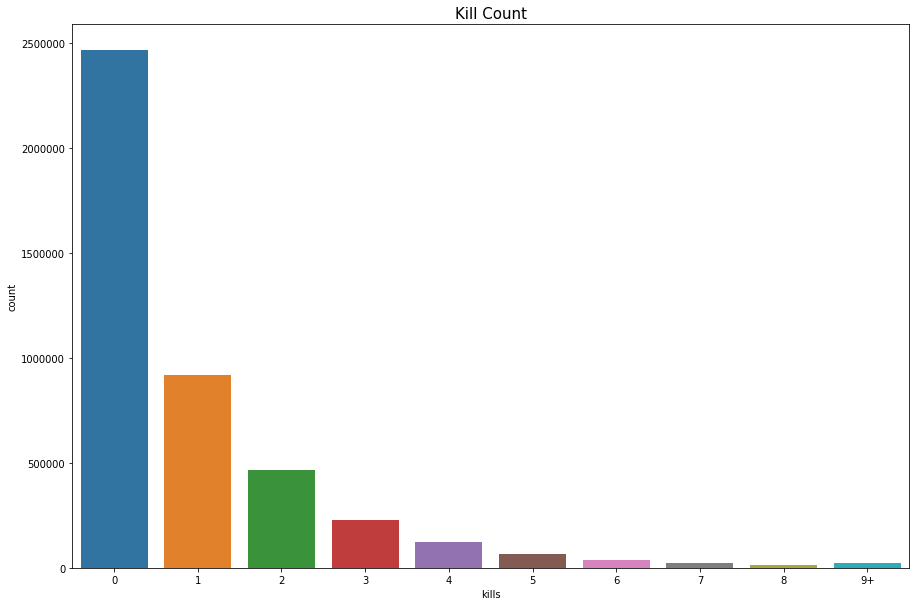

In [38]:
# Checking the killers using Histogram
simplified_kill_data = train_data[['kills']]
simplified_kill_data[simplified_kill_data['kills']>8.9] = '9+'
plt.figure(figsize=(15,10))
sns.countplot(simplified_kill_data['kills'].astype('str').sort_values())
plt.title("Kill Count",fontsize=15)
plt.show()